In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import digamma
from sklearn.gaussian_process import GaussianProcessRegressor
import gpytorch

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

/Users/menang/anaconda3/envs/py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's consider a simpler setting where 
$f(x) = 4 sin(x), x \in [a,b]$, and $y_i$ is bags of each bin with 1/n width. So that $g(y) = E[sin(x)|y] = \frac{1}{max(y) - min(y)}\int_{min(y)}^{max(y)} 4 sin(x) dx = - 4 cos(max(y)) + 4 cos(min(y))$.

In [2]:
def func(x):
    return 4 * np.sin(x)

def ytox(y, a, b, n):
    xs = []
    for i in y:
        # Determine the bin index
        # Calculate bin width
        bin_width = (b - a) / n

        # Determine the bin index
        bin_index = int((i - a) // bin_width)

        # Calculate the lower and upper bounds of the detected bin
        lower_bound = a + bin_index * bin_width
        upper_bound = a + (bin_index + 1) * bin_width
        
        x = np.random.uniform(lower_bound, upper_bound)
        xs.append(x)
        
    return np.array(xs) 

def g(y, a=-4, b=4, n=20, sigma=0.1):
    # Calculate the bin width
   
    # Determine the bin index
    # Calculate bin width
    bin_width = (b - a) / n

    # Determine the bin index
    bin_index = int((y - a) // bin_width)

    # Calculate the lower and upper bounds of the detected bin
    lower_bound = a + bin_index * bin_width
    upper_bound = a + (bin_index + 1) * bin_width

    result = 1.0/(upper_bound - lower_bound) * (- 4 * np.cos(upper_bound) + 4 * np.cos(lower_bound)) + np.random.normal(0, sigma)
        
    return result

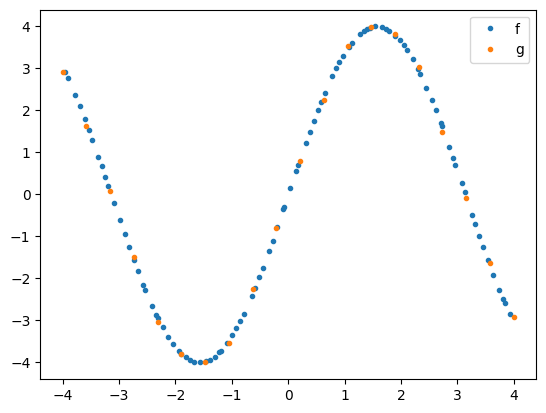

In [3]:
a = -4
b = 4
n = 100
sigma = 0

ys = np.linspace(a,b,100)
xs = ytox(ys, a, b, n)
fs = func(xs)
ys2 = np.linspace(a,b,20)
zs = np.array([g(y, a, b, n, sigma) for y in ys2])
plt.plot(xs, fs, '.', label= 'f')
plt.plot(ys2, zs, '.', label= 'g')
plt.legend()

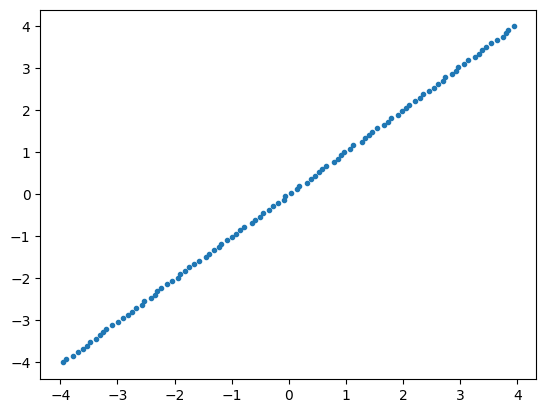

In [4]:
plt.plot(xs, ys, '.')

In [5]:
# muz, sigmaz = zs.mean(), zs.std()
# zs = (zs - muz) / sigmaz
muz, sigmaz = 0, 1 # no normalisation

print('muz: ', muz)
print('sigmaz: ', sigmaz)

muz:  0
sigmaz:  1


In [6]:
import sys
# sys.path.append("../deconditional-downscaling/")
sys.path.append("experiments/swiss_roll/")
from models import build_model, train_model, predict 
import yaml 
import torch

cdf_dir = 'experiments/swiss_roll/config/exact_cmp.yaml' 
# cdf_dir = 'exact_cmp.yaml' 

with open(cdf_dir, "r") as f:
    cfg = yaml.safe_load(f)

cfg['model'].update(individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys2))
model = build_model(cfg['model'])

In [7]:
groundtruth_individuals = torch.tensor(np.linspace(a,b,100)).float()

cfg['training'].update(model=model,
                    individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys2),
                    groundtruth_individuals=groundtruth_individuals,
                    groundtruth_bags_sizes=len(groundtruth_individuals),
                    groundtruth_targets=func(groundtruth_individuals).float(),
                    chunk_size=cfg['evaluation']['chunk_size_nll'],
                    device_idx='cpu',
                    dump_dir='result/'
                    )
train_model(cfg['training'])

In [8]:
predict_kwargs = {'name': cfg['model']['name'],
                'model': model.eval().cpu(),
                'individuals': groundtruth_individuals,
                'bags_sizes': func(groundtruth_individuals)}
individuals_posterior = predict(predict_kwargs)
individuals_posterior_mean = sigmaz * individuals_posterior.mean + muz
# individuals_posterior_mean = individuals_posterior.mean
with torch.no_grad():
    stddev = sigmaz * individuals_posterior.stddev
    # stddev = individuals_posterior.stddev
    lower_bound = individuals_posterior_mean - 2 * stddev
    upper_bound = individuals_posterior_mean + 2 * stddev

In [9]:
individuals_posterior.sample()

tensor([ 1.3360,  1.5191,  1.6427,  1.7525,  1.8443,  1.8550,  1.8417,  1.7702,
         1.6972,  1.5384,  1.3907,  1.1998,  0.9567,  0.7089,  0.4450,  0.1307,
        -0.1947, -0.5607, -0.9437, -1.3325, -1.7537, -2.1975, -2.6504, -3.1018,
        -3.5629, -4.0368, -4.4335, -4.8537, -5.2321, -5.5272, -5.7811, -5.9600,
        -6.0743, -6.1178, -6.0867, -5.9478, -5.7354, -5.4114, -5.0510, -4.5631,
        -4.0615, -3.4699, -2.8405, -2.2140, -1.5681, -0.9170, -0.2924,  0.2659,
         0.7689,  1.2391,  1.6211,  1.9458,  2.2149,  2.4327,  2.6161,  2.7396,
         2.8772,  2.9765,  3.0837,  3.1803,  3.2752,  3.3857,  3.5059,  3.6276,
         3.7608,  3.8261,  3.9440,  4.0041,  4.0728,  4.0856,  4.0983,  4.0681,
         3.9993,  3.9141,  3.8002,  3.6531,  3.4676,  3.2727,  3.0495,  2.7905,
         2.5031,  2.2128,  1.8720,  1.5592,  1.1901,  0.8205,  0.4497,  0.0666,
        -0.3132, -0.6965, -1.0619, -1.3988, -1.7126, -2.0597, -2.3498, -2.5757,
        -2.8017, -2.9793, -3.1555, -3.27

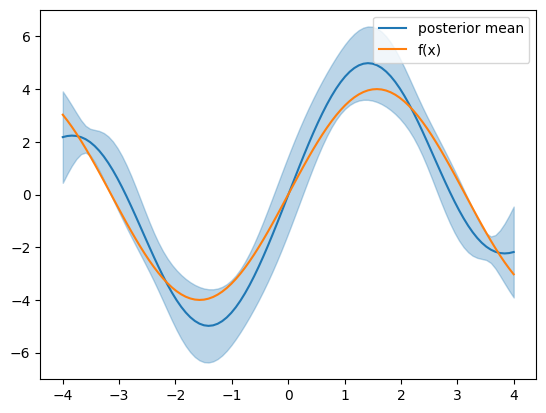

In [10]:
plt.plot(groundtruth_individuals, individuals_posterior_mean, label = 'posterior mean', color='C0')
plt.fill_between(groundtruth_individuals, lower_bound, upper_bound, alpha=0.3, color='C0')
# plt.plot(groundtruth_individuals, (conf[1]-conf[0]).detach().numpy(), label = '2 * posterior std')
plt.plot(groundtruth_individuals, func(groundtruth_individuals), label = 'f(x)', color='C1')
# plt.plot(xs, f(xs), '.', label = 'data points')
plt.legend()

In [11]:
groundtruth_individuals[np.argmin(func(groundtruth_individuals))]

tensor(-1.5758)

In [12]:
groundtruth_individuals[np.argmin(individuals_posterior_mean)]

tensor(-1.4141)

In [13]:
from BO import BayesOpt_UCB, BayesOpt_Random, PES, MES

x_space = torch.tensor(np.linspace(a,b,100)).float() # np.linspace(1e-5,1-1e-5,100)
y_space = torch.tensor(np.linspace(a,b,100)).float() # np.linspace(1e-5,1-1e-5,100)
init_y_size = 3
num_round = 15
num_repeat = 5
random_seeds = np.random.uniform(0,100, num_repeat)

pos_best_dict = {}

xs = torch.from_numpy(xs).float()
ys = torch.from_numpy(ys).float()

  0%|          | 0/1 [00:00<?, ?it/s]

[-2.37914437 -2.34325517 -2.77889805]


_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

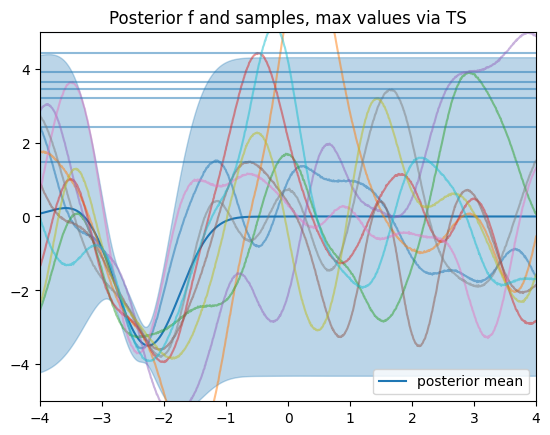

log_pdf_fm:  torch.Size([1, 128, 100, 1])


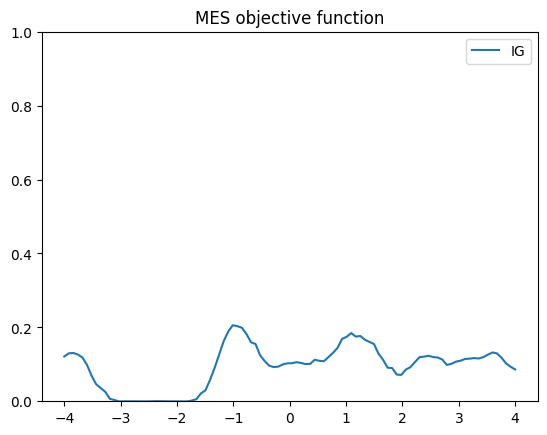

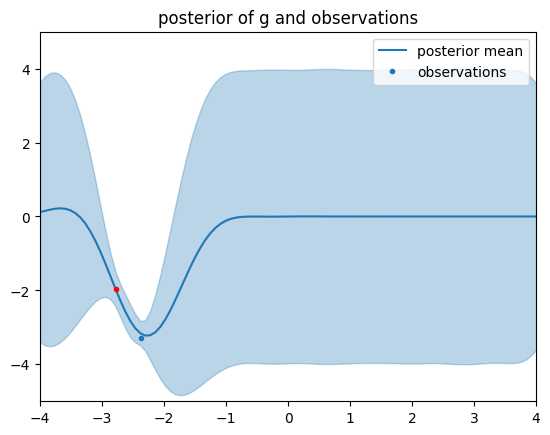

Iteration 1: Elapsed Time: 3.56746506690979 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

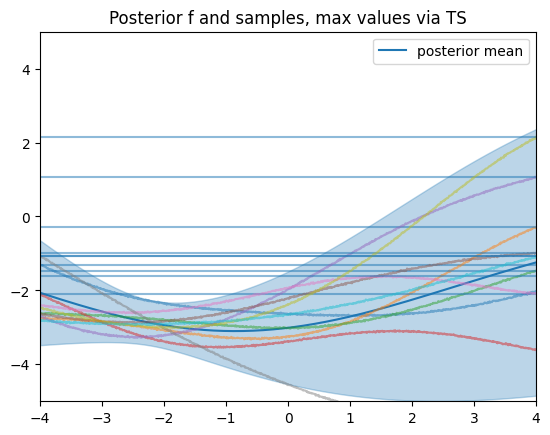

log_pdf_fm:  torch.Size([1, 128, 100, 1])


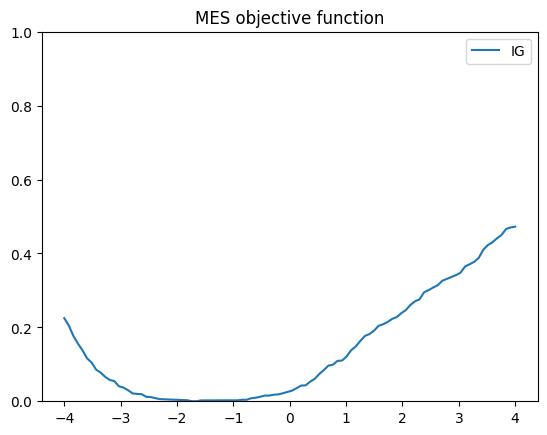

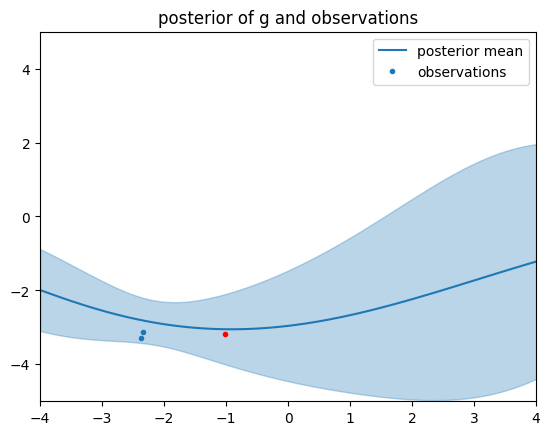


 17%|█▋        | 2/12 [00:07<00:36,  3.70s/it]

Iteration 2: Elapsed Time: 3.7891650199890137 seconds


_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

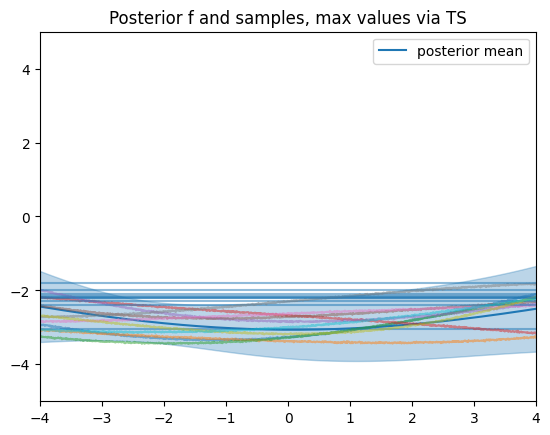

log_pdf_fm:  torch.Size([1, 128, 100, 1])


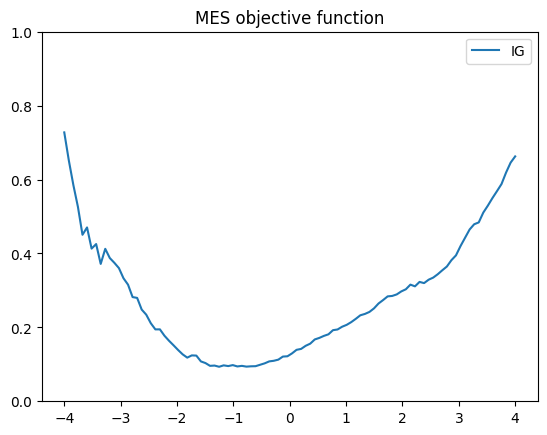

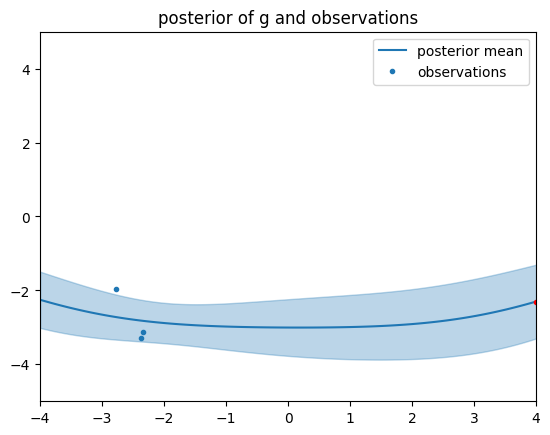

Iteration 3: Elapsed Time: 3.7245731353759766 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

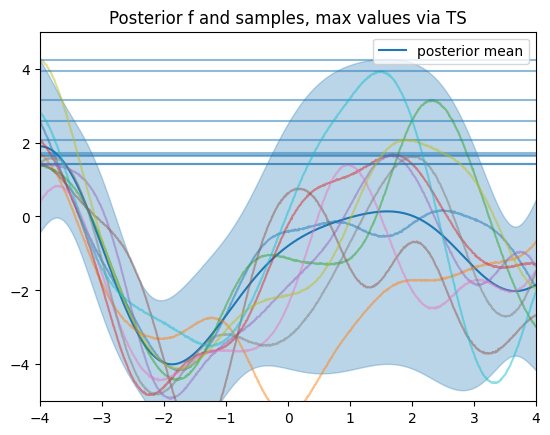

log_pdf_fm:  torch.Size([1, 128, 100, 1])


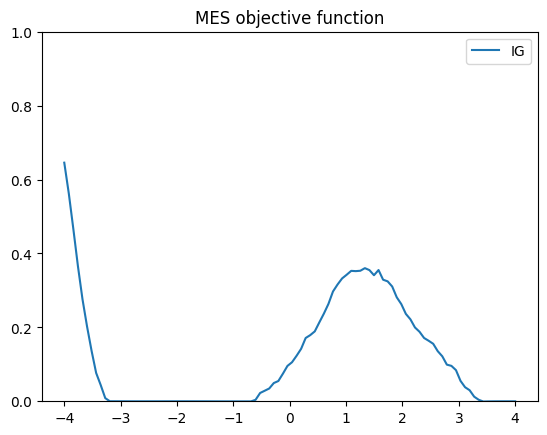

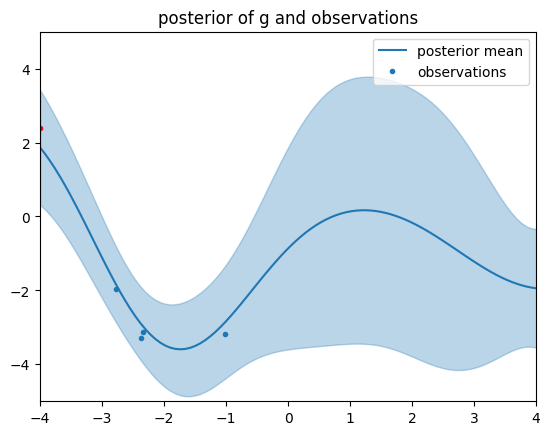

Iteration 4: Elapsed Time: 3.7879440784454346 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

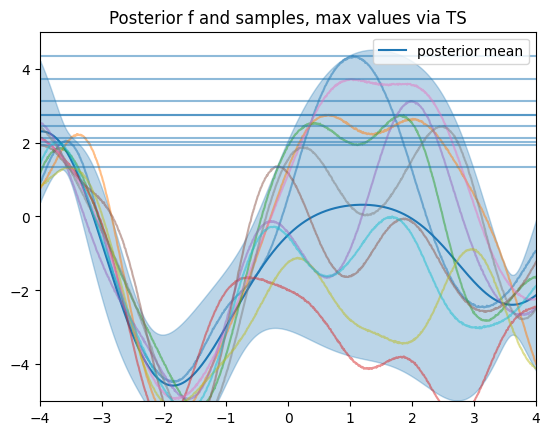

log_pdf_fm:  torch.Size([1, 128, 100, 1])


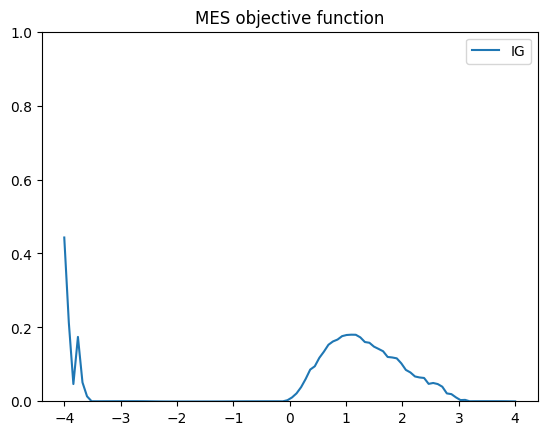

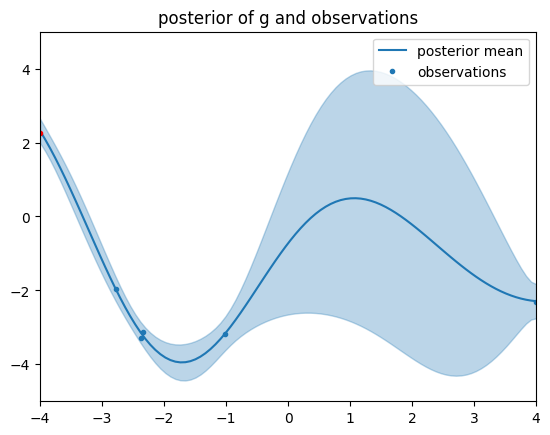

Iteration 5: Elapsed Time: 3.496997833251953 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

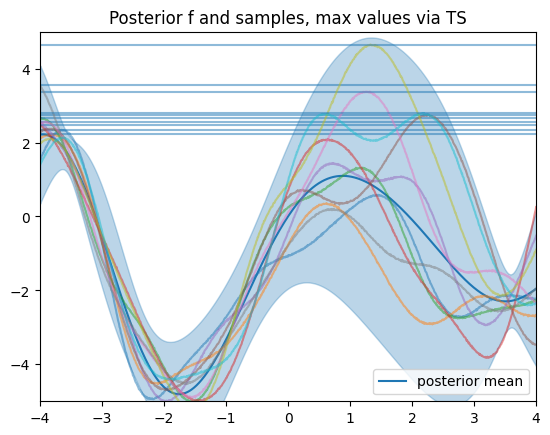

log_pdf_fm:  torch.Size([1, 128, 100, 1])


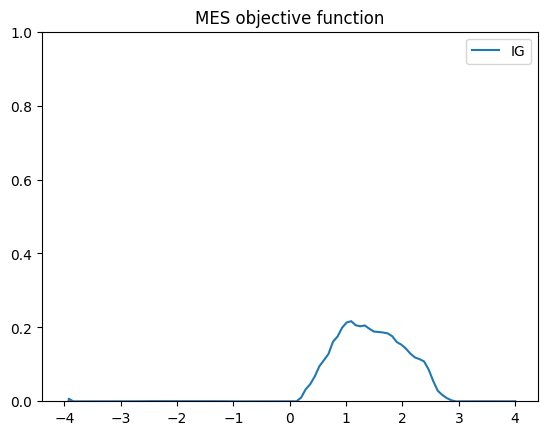

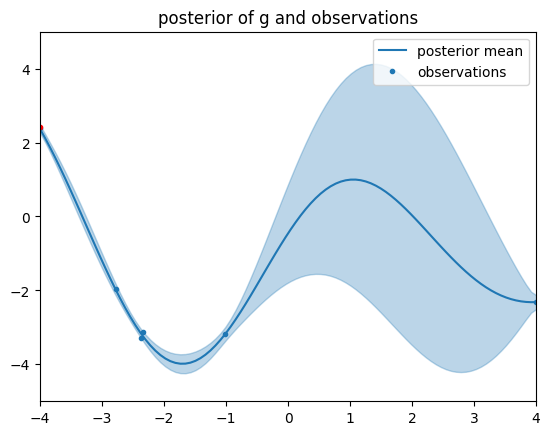

Iteration 6: Elapsed Time: 3.459744691848755 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

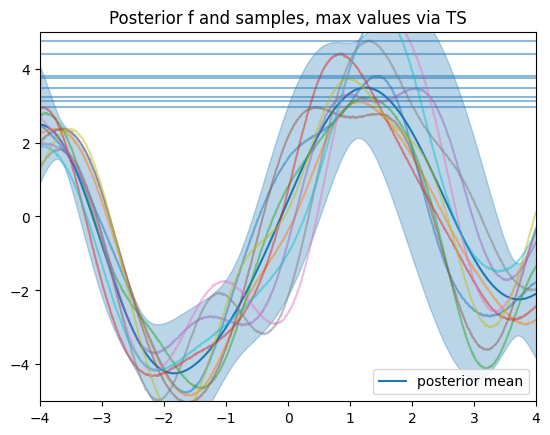

log_pdf_fm:  torch.Size([1, 128, 100, 1])


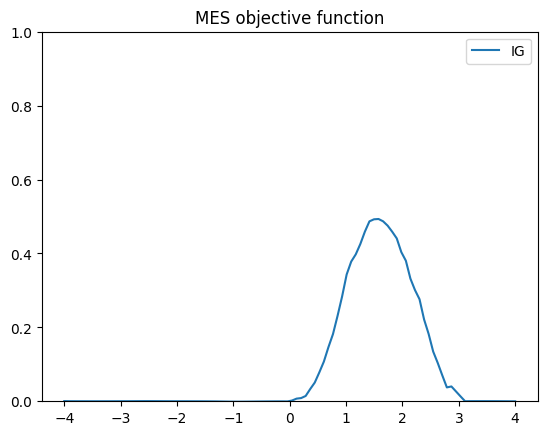

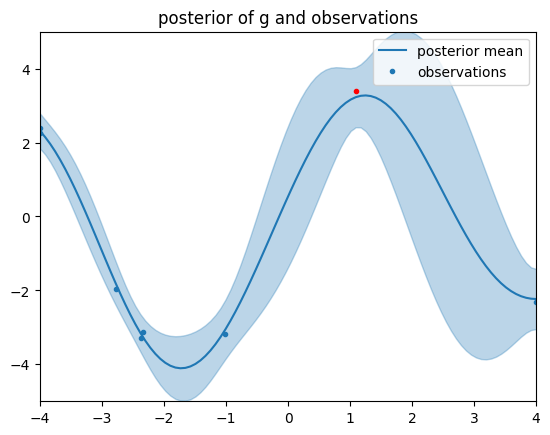

Iteration 7: Elapsed Time: 3.3475639820098877 seconds


 58%|█████▊    | 7/12 [00:25<00:17,  3.51s/it]

_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

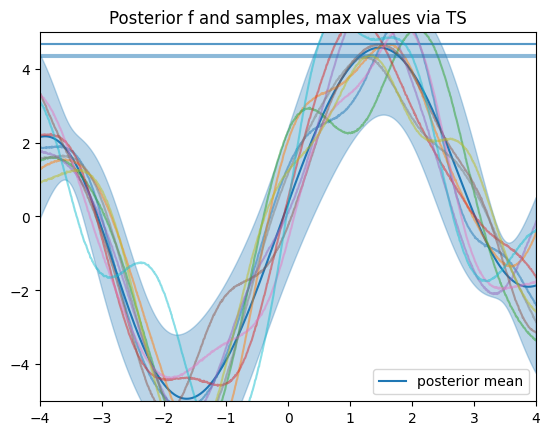

log_pdf_fm:  torch.Size([1, 128, 100, 1])


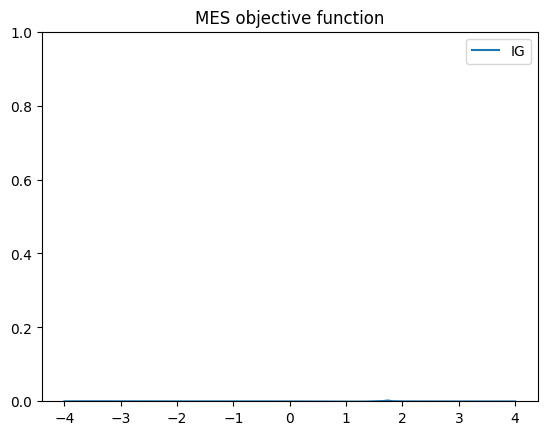

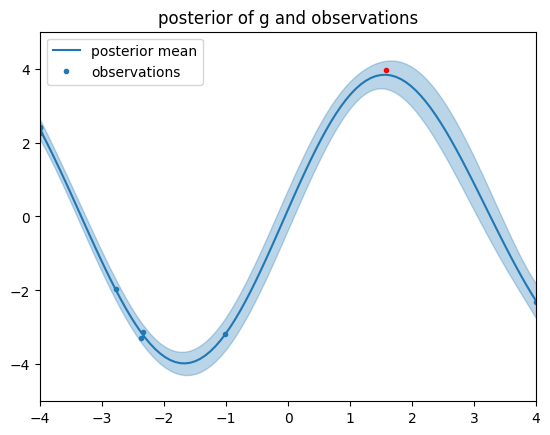

Iteration 8: Elapsed Time: 3.424494743347168 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

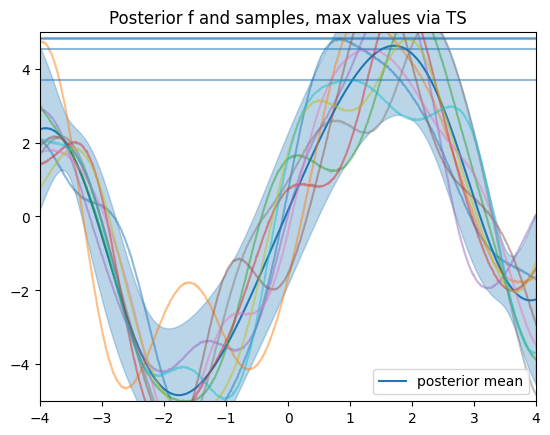

log_pdf_fm:  torch.Size([1, 128, 100, 1])


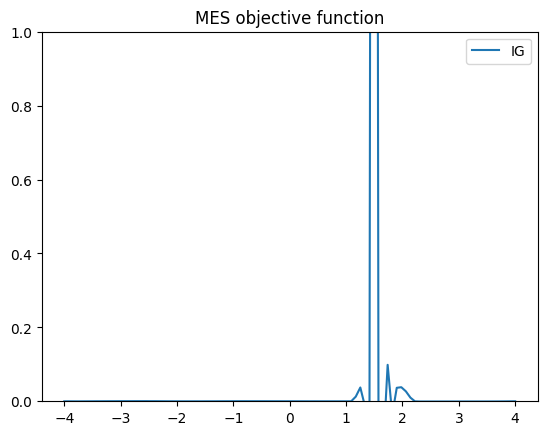

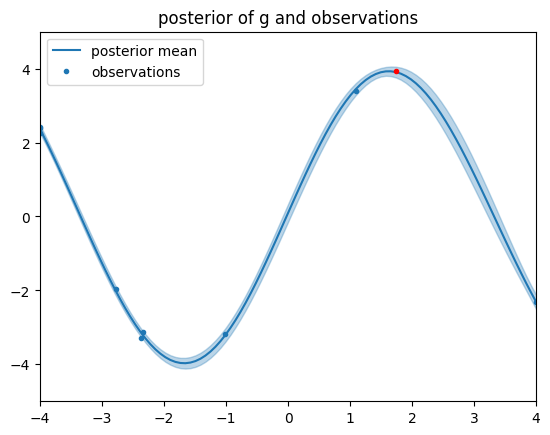

Iteration 9: Elapsed Time: 3.561746120452881 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

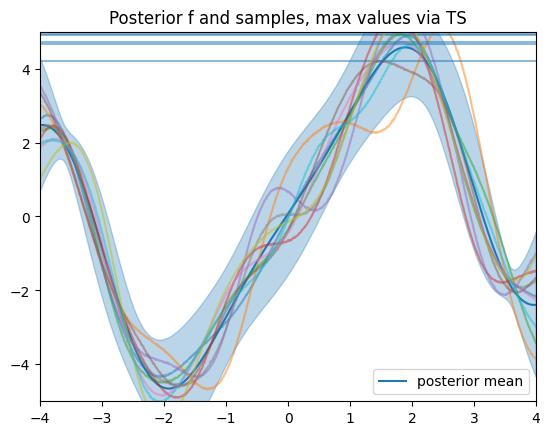

log_pdf_fm:  torch.Size([1, 128, 100, 1])


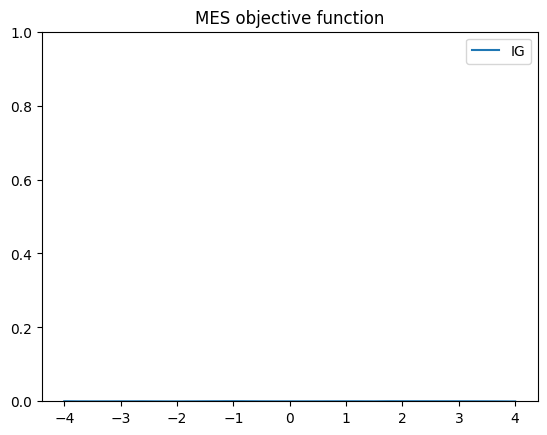

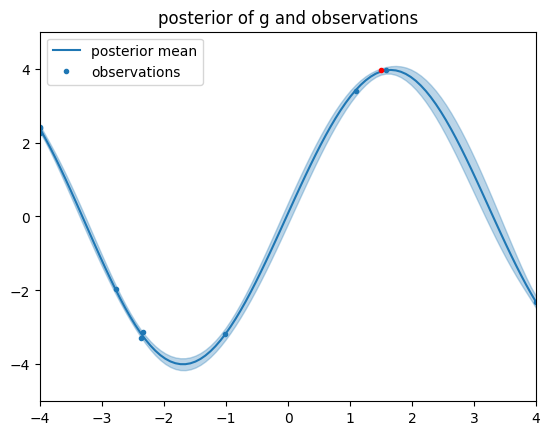

Iteration 10: Elapsed Time: 3.515949010848999 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

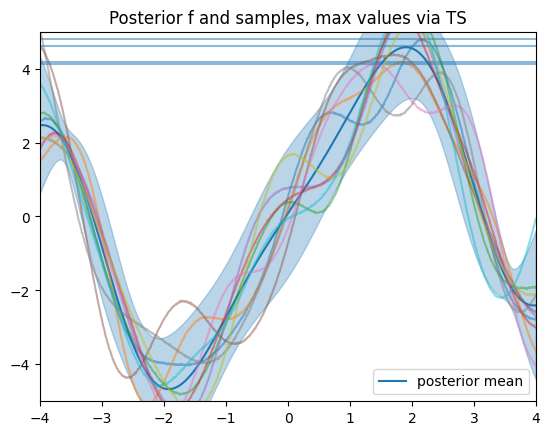

log_pdf_fm:  torch.Size([1, 128, 100, 1])


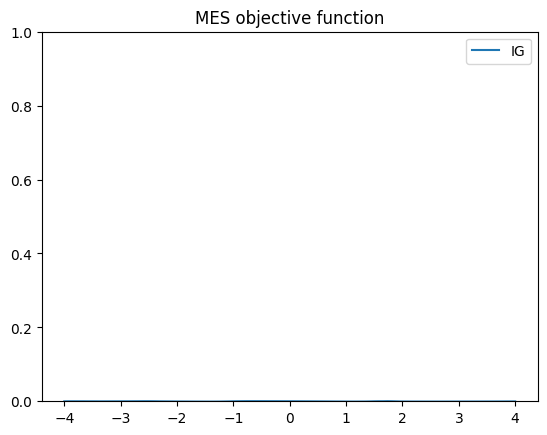

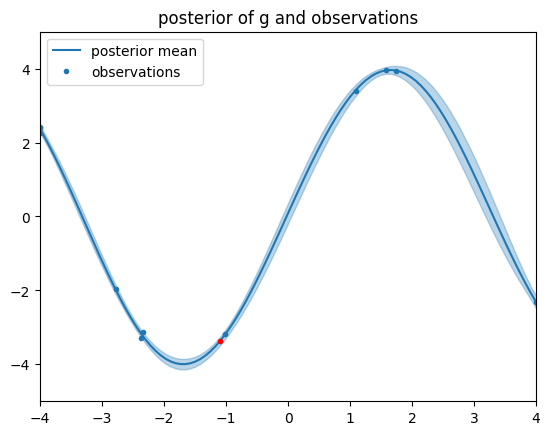

Iteration 11: Elapsed Time: 3.5251212120056152 seconds
_sample_max_value_Thompson
normalise muz:  0
normalise sigmaz:  1


<Figure size 640x480 with 0 Axes>

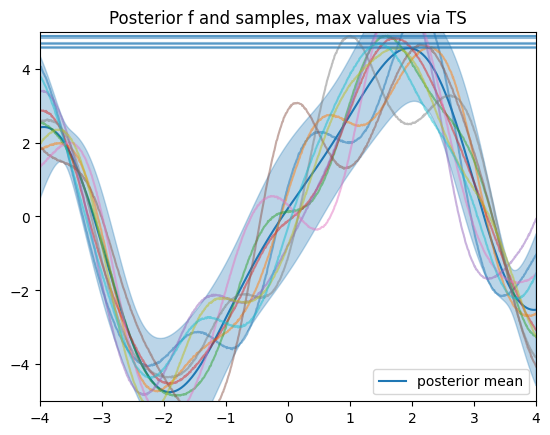

log_pdf_fm:  torch.Size([1, 128, 100, 1])


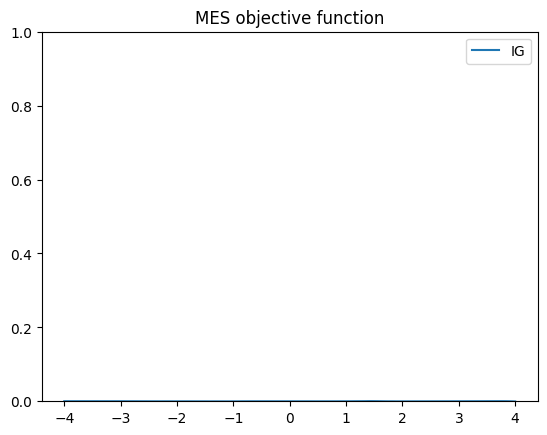

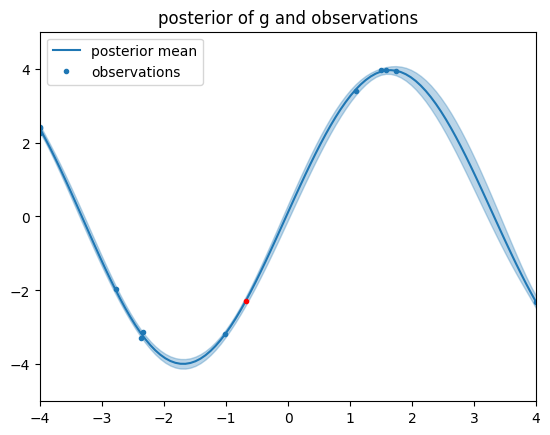

100%|██████████| 12/12 [00:42<00:00,  3.57s/it]

Iteration 12: Elapsed Time: 3.671700954437256 seconds



100%|██████████| 1/1 [00:43<00:00, 43.25s/it]


<Figure size 640x480 with 0 Axes>

In [23]:
num_repeat = 1
agent_mes = MES(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp.yaml', dump_dir='result/mes/', random_seeds=random_seeds)
pos_best_dict['mes'] = agent_mes.simulation()

In [15]:
# agent_pes = PES(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp.yaml', dump_dir='result/pes/',  y_min=-3, λ=0.01, num_opt_samples=10, random_seeds=random_seeds)
# pos_best_dict['pes'] = agent_pes.simulation()

(array([3., 1., 2., 2., 1., 0., 4., 1., 0., 1.]),
 array([-4.        , -3.20000005, -2.4000001 , -1.60000002, -0.80000001,
         0.        ,  0.80000001,  1.60000002,  2.4000001 ,  3.20000005,
         4.        ]),
 <BarContainer object of 10 artists>)

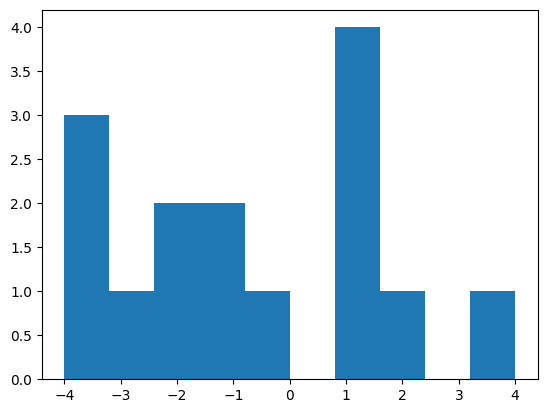

In [24]:
plt.hist(agent_mes.y_recs)

In [17]:
# agent_ucb = BayesOpt_UCB(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/ucb/', random_seeds=random_seeds)
# pos_best_dict['ucb'] = agent_ucb.simulation()

In [18]:
agent_random = BayesOpt_Random(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp.yaml', dump_dir='result/random/', random_seeds=random_seeds)
pos_best_dict['random']= agent_random.simulation()

  0%|          | 0/5 [00:00<?, ?it/s]

[-2.37914437 -2.34325517 -2.77889805]


Iteration 1: Elapsed Time: 3.0745809078216553 seconds


Iteration 2: Elapsed Time: 3.128217935562134 seconds


Iteration 3: Elapsed Time: 2.9900238513946533 seconds


Iteration 4: Elapsed Time: 3.071199893951416 seconds


Iteration 5: Elapsed Time: 3.1663920879364014 seconds


Iteration 6: Elapsed Time: 3.0555670261383057 seconds


Iteration 7: Elapsed Time: 3.012744188308716 seconds


Iteration 8: Elapsed Time: 3.0855140686035156 seconds


Iteration 9: Elapsed Time: 3.4638657569885254 seconds


Iteration 10: Elapsed Time: 3.132167100906372 seconds


Iteration 11: Elapsed Time: 3.141132116317749 seconds


100%|██████████| 12/12 [00:37<00:00,  3.13s/it]

Iteration 12: Elapsed Time: 3.166531801223755 seconds



 20%|██        | 1/5 [00:37<02:31, 37.87s/it]

[-0.51204078 -3.79259015  0.39729982]


Iteration 1: Elapsed Time: 3.040109157562256 seconds


Iteration 2: Elapsed Time: 3.0914289951324463 seconds


Iteration 3: Elapsed Time: 3.083843946456909 seconds


Iteration 4: Elapsed Time: 3.0844650268554688 seconds


Iteration 5: Elapsed Time: 3.042699098587036 seconds


Iteration 6: Elapsed Time: 3.1809580326080322 seconds


Iteration 7: Elapsed Time: 3.128932237625122 seconds


Iteration 8: Elapsed Time: 3.121896266937256 seconds


Iteration 9: Elapsed Time: 3.119330883026123 seconds


Iteration 10: Elapsed Time: 3.1358940601348877 seconds


Iteration 11: Elapsed Time: 3.053074836730957 seconds


100%|██████████| 12/12 [00:37<00:00,  3.11s/it]

Iteration 12: Elapsed Time: 3.1675519943237305 seconds



 40%|████      | 2/5 [01:15<01:53, 37.72s/it]

[1.14151933 0.30896745 0.09518386]


Iteration 1: Elapsed Time: 3.459733009338379 seconds


Iteration 2: Elapsed Time: 3.1198060512542725 seconds


Iteration 3: Elapsed Time: 3.1917920112609863 seconds


Iteration 4: Elapsed Time: 3.0348129272460938 seconds


Iteration 5: Elapsed Time: 3.1203179359436035 seconds


Iteration 6: Elapsed Time: 2.973123788833618 seconds


Iteration 7: Elapsed Time: 3.146512985229492 seconds


Iteration 8: Elapsed Time: 3.0171420574188232 seconds


Iteration 9: Elapsed Time: 3.100802183151245 seconds


Iteration 10: Elapsed Time: 3.0741500854492188 seconds


Iteration 11: Elapsed Time: 3.8669209480285645 seconds


100%|██████████| 12/12 [00:38<00:00,  3.18s/it]

Iteration 12: Elapsed Time: 3.055424213409424 seconds



 60%|██████    | 3/5 [01:54<01:16, 38.09s/it]

[-1.15664706 -1.27320899  3.46485154]


Iteration 1: Elapsed Time: 3.118039131164551 seconds


Iteration 2: Elapsed Time: 3.0259640216827393 seconds


Iteration 3: Elapsed Time: 3.0129449367523193 seconds


Iteration 4: Elapsed Time: 3.139430284500122 seconds


Iteration 5: Elapsed Time: 2.9997520446777344 seconds


Iteration 6: Elapsed Time: 3.0248899459838867 seconds


Iteration 7: Elapsed Time: 3.120712995529175 seconds


Iteration 8: Elapsed Time: 3.0206298828125 seconds


Iteration 9: Elapsed Time: 3.037851095199585 seconds


Iteration 10: Elapsed Time: 3.0662078857421875 seconds


Iteration 11: Elapsed Time: 3.1019551753997803 seconds


100%|██████████| 12/12 [00:36<00:00,  3.06s/it]

Iteration 12: Elapsed Time: 3.0867347717285156 seconds



 80%|████████  | 4/5 [02:31<00:37, 37.70s/it]

[ 2.77329926  0.48932432 -0.36099678]


Iteration 1: Elapsed Time: 3.0199649333953857 seconds


Iteration 2: Elapsed Time: 3.1161210536956787 seconds


Iteration 3: Elapsed Time: 3.2036449909210205 seconds


Iteration 4: Elapsed Time: 3.020261764526367 seconds


Iteration 5: Elapsed Time: 159.9520971775055 seconds


Iteration 6: Elapsed Time: 3.317819118499756 seconds


Iteration 7: Elapsed Time: 3.2249910831451416 seconds


Iteration 8: Elapsed Time: 3.1512579917907715 seconds


Iteration 9: Elapsed Time: 3.029109001159668 seconds


Iteration 10: Elapsed Time: 3.049283742904663 seconds


Iteration 11: Elapsed Time: 3.014918804168701 seconds


100%|██████████| 12/12 [03:14<00:00, 16.18s/it]

Iteration 12: Elapsed Time: 3.025009870529175 seconds



100%|██████████| 5/5 [05:45<00:00, 69.12s/it]


<Figure size 640x480 with 0 Axes>

(array([2., 0., 2., 0., 1., 2., 3., 1., 0., 4.]),
 array([-3.61892247, -2.93903446, -2.25914669, -1.5792588 , -0.89937091,
        -0.21948302,  0.46040487,  1.14029276,  1.82018065,  2.50006866,
         3.17995644]),
 <BarContainer object of 10 artists>)

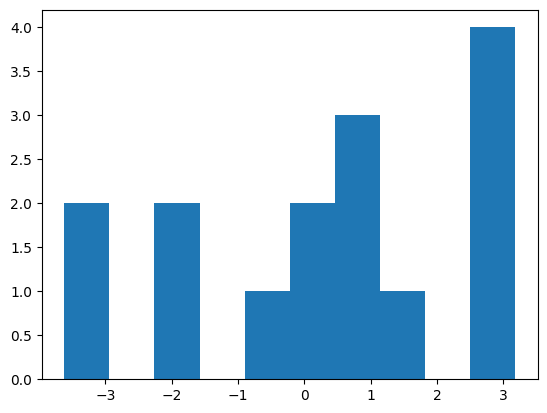

In [19]:
plt.hist(agent_random.y_recs)

In [20]:
def evalaution(pos_best_dict):
    # plt.plot(range(self.n), self.z_rewards[self.init_y_recs_size:], '.', label = 'z rewards')
    for name, pos_bests in pos_best_dict.items():
        opt = np.min(func(x_space.numpy()))
        regret_mean =np.abs(opt - pos_bests).mean(axis=0)
        regret_std =np.abs(opt - pos_bests).std(axis=0)
        # print(regret_mean)
        plt.plot(range(len(regret_mean)), regret_mean, label = name)
        plt.fill_between(range(len(regret_mean)), regret_mean - 2 * regret_std, regret_mean + 2 * regret_std, alpha = 0.3)
    # plt.ylim(0,2)
    plt.legend()
    plt.xlabel('Round')
    plt.ylabel('Regret')  

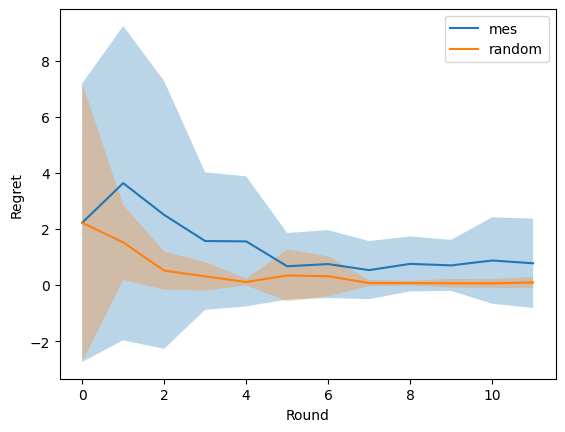

In [21]:
evalaution(pos_best_dict)

In [22]:
# np.save('pos-seed24.npy', pos_best_dict)